# Emotion detection in song lyrics

In [1]:
import pandas as pd
import numpy as np
from tqdm.auto import tqdm

## Data Import

In [2]:
# Importing EmoBank datasets
path = "Data/EmoBank-master/corpus/"

raw = pd.read_csv(path+'raw.csv') # Text
reader = pd.read_csv(path+'reader.csv') # VAD values
meta = pd.read_csv(path+'meta.tsv', sep='\t') # Category

In [3]:
# Retrieving useful columns
reader = reader.iloc[:, :4]
meta = meta.iloc[:, :3]

In [4]:
from functools import reduce

# Merging dataframes
dfs = [raw, reader, meta]
data = reduce(lambda  left, right: pd.merge(left, right, on=['id']), dfs)

In [5]:
# Map VAD scores on the range [-1, 1]
from scipy.interpolate import interp1d

range_map = interp1d([1, 5], [-1, 1])
data.iloc[:, 2:5] = range_map(data.iloc[:, 2:5])

In [6]:
data.head()

,id,text,V,A,D,document,category
0,Acephalous-Cant-believe_4_47,I can't believe I wrote all that last year.,0.0,0.2,0.1,Acephalous-Cant-believe,blog
1,Acephalous-Cant-believe_83_354,Because I've been grading all damn day and am ...,-0.1,0.1,0.1,Acephalous-Cant-believe,blog
2,Acephalous-Cant-believe_355_499,"However, when I started looking through my arc...",0.2,0.0,0.1,Acephalous-Cant-believe,blog
3,Acephalous-Cant-believe_500_515,What do I mean?,0.0,0.0,0.0,Acephalous-Cant-believe,blog
4,Acephalous-Cant-believe_517_626,The posts I consider foundational to my curren...,0.0,0.0,0.0,Acephalous-Cant-believe,blog


## Text Preprocessing

In [7]:
import spacy
import string
import contractions
import nltk
from nltk.corpus import stopwords

nlp = spacy.load("en_core_web_sm")
punct = string.punctuation
sw = stopwords.words('english')

def text_preproc(text):
    """
    text: string to tokenize
    
    Normalize the input, lower characters, extend contractions, 
    remove functional punctuation, retrieve lemmas.
    Return a list of words.
    """
    text = text.lower()
    text = contractions.fix(text)
    text = "".join([char for char in text if char not in punct])
    text = nlp(text)
    
    doc = []
    for word in text:
        if word.orth_ not in sw:
            doc.append(word.lemma_)
        
    return doc

In [8]:
data['tokens'] = data['text'].apply(lambda x: text_preproc(x))

In [9]:
data.iloc[:, [1, 7]].head()

,text,tokens
0,I can't believe I wrote all that last year.,"[believe, write, last, year]"
1,Because I've been grading all damn day and am ...,"[I, grade, damn, day, tired, swearengen, hear,..."
2,"However, when I started looking through my arc...","[however, start, look, archive, occur, output,..."
3,What do I mean?,[mean]
4,The posts I consider foundational to my curren...,"[post, consider, foundational, current, profes..."


## Embedding

In [10]:
import gensim.downloader as api
w2v = api.load('word2vec-google-news-300')

/Users/sergiopicascia/opt/anaconda3/lib/python3.8/site-packages/gensim/similarities/__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


In [11]:
def sent2vec(sent):
    
    vectors = []
    for word in sent:
        try:
            vectors.append(w2v.get_vector(word))
        except:
            pass
    
    if not vectors:
        return np.zeros(300)
        
    avg = np.mean(vectors, axis=0)
    
    return avg

In [12]:
data['vector'] = data['tokens'].apply(lambda x: sent2vec(x))

In [13]:
data['vector'].head()

0    [0.00024414062, 0.03981018, 0.026187897, 0.036...
1    [0.07705966, 0.04738617, -0.018334128, 0.14133...
2    [0.006500244, 0.098587036, -0.008660634, 0.114...
3    [-0.061279297, -0.068359375, 0.12011719, 0.191...
4    [0.042907715, -0.009309769, 0.0030002594, 0.04...
Name: vector, dtype: object

## Regression Model

In [14]:
# Define variables
X = pd.DataFrame(data['vector'].values.tolist())
y = data[['V', 'A', 'D']]

In [15]:
import tensorflow
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, LeakyReLU
from tensorflow.keras import initializers

def baseline_model():
    model = Sequential()
    model.add(Dense(16, input_dim=300, kernel_initializer='he_normal'))
    model.add(LeakyReLU(alpha=0.01))
    model.add(Dropout(0.5))
    model.add(Dense(8, kernel_initializer='he_normal'))
    model.add(LeakyReLU(alpha=0.01))
    model.add(Dropout(0.5))
    model.add(Dense(3, activation='linear'))

    model.compile(loss='mse', optimizer='adam')
    
    return model

In [16]:
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

model = KerasRegressor(build_fn=baseline_model, epochs=100, batch_size=10, verbose=0)
kfold = KFold(n_splits=5)
scores = cross_val_score(model, X, y, cv=kfold)

In [17]:
print('MSE:', -scores.mean())

MSE: 0.026688505336642264


In [18]:
model.fit(X, y)

## VAD to Categories

### 1st approach

In [19]:
# Importing SemEval datasets
path2 = 'Data/AffectiveText.Semeval.2007/'

sem_eval1 = pd.read_csv(path2+'AffectiveText.trial/affectivetext_trial.emotions.gold', 
                        header=None, sep=' ', index_col=0)
sem_eval2 = pd.read_csv(path2+'AffectiveText.test/affectivetext_test.emotions.gold', 
                        header=None, sep=' ', index_col=0)

In [20]:
# Renaming columns
sem_eval_em = pd.concat([sem_eval1, sem_eval2]).rename(columns={0:'id', 1:'anger', 2:'disgust', 
                                                                3:'fear', 4:'joy', 5:'sadness', 
                                                                6:'surprise'})
sem_eval_em.index.name = None

In [21]:
sem_eval_em.head()

,anger,disgust,fear,joy,sadness,surprise
1,22,2,60,0,64,0
2,0,0,0,93,0,38
3,18,0,52,66,20,65
4,66,39,94,0,86,0
5,0,0,25,26,2,46


In [22]:
# Importing EmoBank dataset to perform analysis on mixed values
emobank = pd.read_csv(path+'emobank.csv') # EmoBank
emobank = emobank.iloc[:, [0, 2, 3, 4]]

# Merging dataframes
dfs = [raw, emobank, meta]
emobank = reduce(lambda  left, right: pd.merge(left, right, on=['id']), dfs)
emobank.head()

,id,text,V,A,D,document,category
0,Acephalous-Cant-believe_4_47,I can't believe I wrote all that last year.,3.1,3.4,3.1,Acephalous-Cant-believe,blog
1,Acephalous-Cant-believe_83_354,Because I've been grading all damn day and am ...,2.5,3.5,3.5,Acephalous-Cant-believe,blog
2,Acephalous-Cant-believe_355_499,"However, when I started looking through my arc...",3.5,3.2,3.5,Acephalous-Cant-believe,blog
3,Acephalous-Cant-believe_500_515,What do I mean?,3.0,3.1,2.9,Acephalous-Cant-believe,blog
4,Acephalous-Cant-believe_517_626,The posts I consider foundational to my curren...,3.0,3.0,3.1,Acephalous-Cant-believe,blog


In [23]:
# Retrieving SemEval data from EmoBank
sem_eval_vad = emobank[emobank['category']=='SemEval'].iloc[:, [0, 2, 3, 4]]

# Recreating same index as sem_eval_em
sem_eval_vad['id'] = sem_eval_vad['id'].apply(lambda x: x.replace('SemEval_', ''))
sem_eval_vad.set_index('id', inplace=True)
sem_eval_vad.index.name = None
sem_eval_vad.index = sem_eval_vad.index.astype('int64')

sem_eval_vad.head()

,V,A,D
1,2.29,3.29,2.86
2,3.70,2.90,3.10
3,3.50,3.40,3.30
4,2.11,3.11,3.00
5,3.22,3.44,3.44


In [24]:
# Merge VAD values with Emotions' ones
sem_eval = pd.merge(sem_eval_vad, sem_eval_em, left_index=True, right_index=True)
sem_eval.head()

,V,A,D,anger,disgust,fear,joy,sadness,surprise
1,2.29,3.29,2.86,22,2,60,0,64,0
2,3.70,2.90,3.10,0,0,0,93,0,38
3,3.50,3.40,3.30,18,0,52,66,20,65
4,2.11,3.11,3.00,66,39,94,0,86,0
5,3.22,3.44,3.44,0,0,25,26,2,46


In [25]:
# Train and test split for regression task
from sklearn.model_selection import train_test_split

X, y = np.split(sem_eval, [3], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, shuffle=True, random_state=123)

In [26]:
# Decision Tree Regression
from sklearn.tree import DecisionTreeRegressor

regTree = DecisionTreeRegressor().fit(X_train, y_train)
regTree.score(X_train, y_train), regTree.score(X_test, y_test)

(0.8226080089381597, -0.3276679925865931)

In [27]:
# MSE for Decision Tree Regression
from sklearn.metrics import mean_squared_error

mean_squared_error(y_train, regTree.predict(X_train)), mean_squared_error(y_test, regTree.predict(X_test))

(54.0302513782708, 378.5629734350737)

In [28]:
# One-hot encode continuous value according to a given threshold (presence/non-presence of emotion)
sem_eval_em_oh = sem_eval_em >= 50
sem_eval_em_oh = sem_eval_em_oh.astype('int')
sem_eval = pd.merge(sem_eval_vad, sem_eval_em_oh, left_index=True, right_index=True)
sem_eval.head()

,V,A,D,anger,disgust,fear,joy,sadness,surprise
1,2.29,3.29,2.86,0,0,1,0,1,0
2,3.70,2.90,3.10,0,0,0,1,0,0
3,3.50,3.40,3.30,0,0,1,1,0,1
4,2.11,3.11,3.00,1,0,1,0,1,0
5,3.22,3.44,3.44,0,0,0,0,0,0


In [29]:
# Train and test split for classification task
X, y = np.split(sem_eval, [3], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, shuffle=True, random_state=123)

In [30]:
# Decision Tree Classifier
from sklearn.tree import DecisionTreeClassifier

tree = DecisionTreeClassifier(criterion='entropy', random_state=123).fit(X_train, y_train)
tree.score(X_train, y_train), tree.score(X_test, y_test)

(0.8982161594963274, 0.5606694560669456)

In [31]:
# Evaluation metrics
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score

y_pred = tree.predict(X_test)

accuracy_score(y_test, y_pred), \
recall_score(y_test, y_pred, average=None), \
precision_score(y_test, y_pred, average=None), \
f1_score(y_test, y_pred, average=None)

(0.5606694560669456,
 array([0.25      , 0.        , 0.08695652, 0.3       , 0.41935484,
        0.1       ]),
 array([0.11111111, 0.        , 0.08333333, 0.52941176, 0.65      ,
        0.09090909]),
 array([0.15384615, 0.        , 0.08510638, 0.38297872, 0.50980392,
        0.0952381 ]))

In [32]:
# Confusion matrix
from sklearn.metrics import confusion_matrix

confusion_matrix(y_test.iloc[:, 0], y_pred[:, 0])

array([[227,   8],
       [  3,   1]])

### 2nd approach

In [33]:
# Define Ekman's emotions coordinates in VAD space according to Mehrabian and Russell (1977)
emo_coord = {
    'anger': (-0.51, 0.59, 0.25),
    'disgust': (-0.6, 0.35, 0.11),
    'fear': (-0.64, 0.60, -0.43),
    'joy': (0.74, 0.48, 0.35),
    'sadness': (-0.63, -0.27, -0.33),
    'surprise': (0.4, 0.67, -0.13)
}

<IPython.core.display.Javascript object>


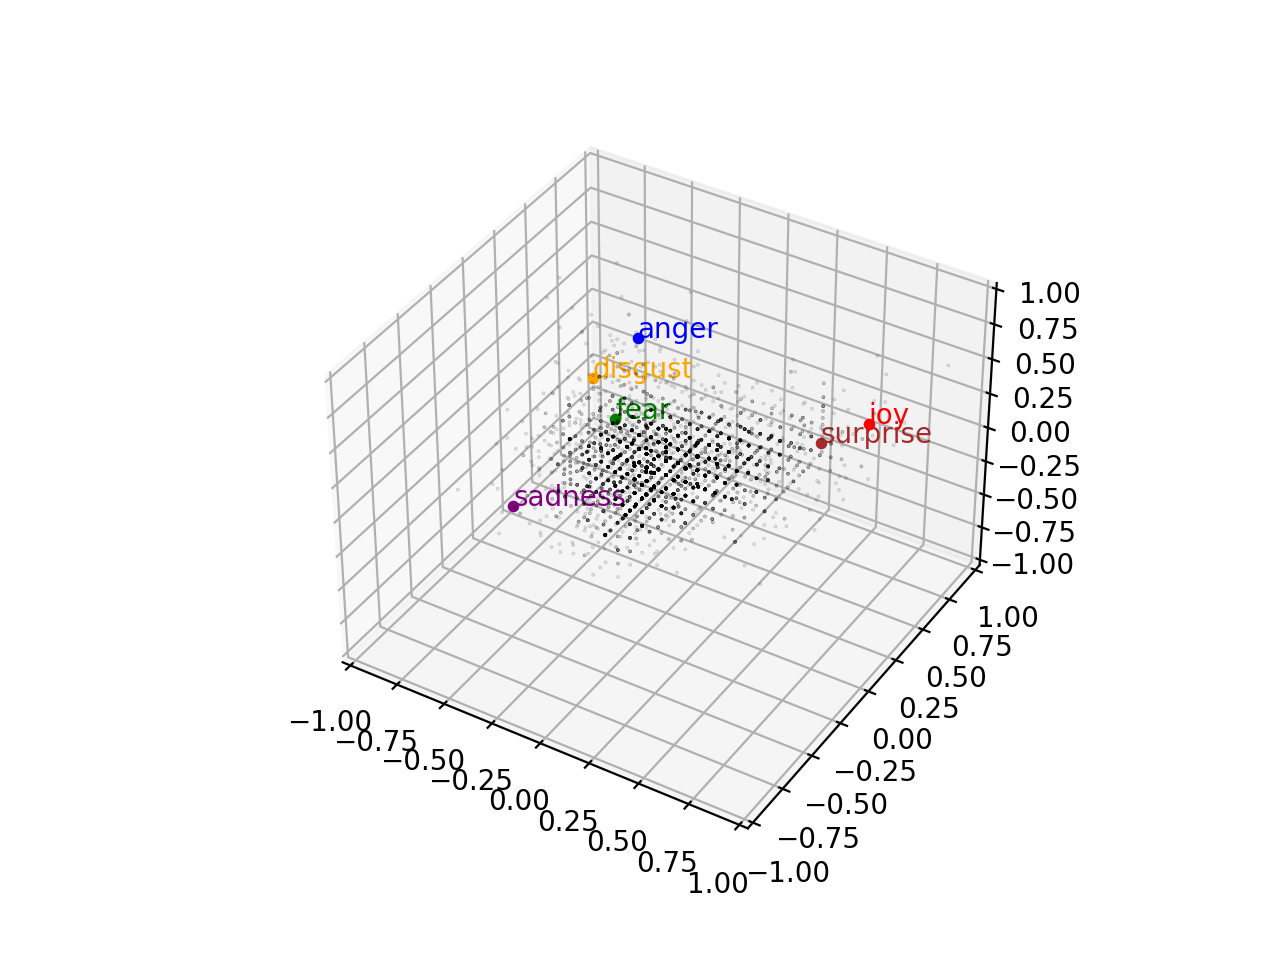

In [42]:
# Plot EmoBank data in VAD space
%matplotlib notebook
#from mpl_toolkits import mplot3d
import matplotlib.pyplot as plt

fig = plt.figure()
ax = plt.axes(projection='3d')
ax.scatter(data['V'], data['A'], data['D'], s=.1, c='black', alpha=.2)
ax.set_xlim(-1, 1), ax.set_ylim(-1, 1), ax.set_zlim(-1, 1)

colors = ['blue', 'orange', 'green', 'red', 'purple', 'brown']

for idx, (key, value) in enumerate(emo_coord.items()):
    ax.scatter(value[0], value[1], value[2], s=10, c=colors[idx])
    ax.text(value[0], value[1], value[2], key, color=colors[idx])

plt.show()

In [35]:
from scipy.spatial import distance

# Distance of each emotion from the center
for emo, coord in emo_coord.items():
    print(emo, distance.euclidean((0, 0, 0), coord))

anger 0.8189627586160435
disgust 0.7032780389006896
fear 0.976985158536198
joy 0.9489467845985885
sadness 0.760723339986358
surprise 0.7910752176626443


In [36]:
def vad_to_em(x):
    
    """
    x: DataFrame entry of VAD values
    
    For each observation, compute the distances from the point
    to each of the different emotions. Assign each point to the
    closest one, unless it can be considered a neutral sentence
    being too close to the center.
    """
    
    x = x.to_numpy()
    emotion = ''
    dist = 1
    
    if distance.euclidean(x, (0, 0, 0)) < 0.4:
        return emotion
    else:
        for emo, coord in emo_coord.items():
            new_dist = distance.euclidean(x, coord)
            if new_dist < dist:
                emotion = emo
                dist = new_dist
    
    return emotion

In [37]:
# Generate a variable emotion using the function above
data['emotion'] = data.apply(lambda x: vad_to_em(x[2:5]), axis=1)

In [38]:
# Observations assigned to each emotion
data['emotion'].value_counts()

            8453
disgust      539
joy          510
sadness      419
surprise     230
fear          96
anger         78
Name: emotion, dtype: int64

## Lyrics Dataset

In [39]:
# Use Genius API and library 'lyricsgenius' to retrieve information about songs
import lyricsgenius as lg

genius = lg.Genius('E60-Z9CYOy7qOQ003Bgl8cuMgtzecGTYQLBOwb4r6MsQYRn6eenLoqqLNm_W4NiZ',
                             skip_non_songs=True, remove_section_headers=True, retries=3)



def get_songs(pages=1, period='all_time'):
    """
    pages: number of pages to consider (each page has 50 items)
    period: time period which the charts refer to ('all_time', 'month', 'week', 'day')
    
    For each genre, retrieve the charts based on the time period they refer to.
    Each chart is composed of items (songs), whose quantity is defined by pages*50.
    For each song, retrieve id, title, artist and genre.
    Return the list of songs.
    """
    
    genres = ['rap', 'pop', 'rb', 'rock', 'country']
    songs = []
    
    for genre in genres:
        for page in range(1, pages+1):
            items = genius.charts(time_period=period, chart_genre=genre, 
                                  per_page=50, page=page)['chart_items']
            for item in items:
                song = item['item']
                songs.append([song['id'], song['title'].replace('\u200b', ''), 
                              song['primary_artist']['name'], genre])
                
    return pd.DataFrame(songs, columns=['id', 'title', 'artist', 'genre'])

In [40]:
songs_db = get_songs(pages=2)
songs_db.head()

,id,title,artist,genre
0,235729,Rap God,Eminem,rap
1,5832126,WAP,Cardi B,rap
2,3039923,HUMBLE.,Kendrick Lamar,rap
3,2845980,Bad and Boujee,Migos,rap
4,3315890,God’s Plan,Drake,rap


In [43]:
# Given song's id, retrieve its lyrics 
tqdm.pandas()
songs_db['lyrics'] = songs_db['id'].progress_apply(lambda x: genius.lyrics(x))
songs_db['lyrics'].head()

  0%|          | 0/490 [00:00<?, ?it/s]

0    "Look, I was gonna go easy on you not to hurt ...
1    Whores in this house\nThere's some whores in t...
2    Nobody pray for me\nIt been that day for me\nW...
3    You know, young rich niggas\nYou know somethin...
4    And they wishin' and wishin' and wishin' and w...
Name: lyrics, dtype: object

In [44]:
def get_tokens(lyrics):
    """
    lyrics: text of the song
    Given the lyrics, split the text in sentences,
    removing unicode characters. Then, tokenize and 
    normalize each sentence.
    """
    
    text = lyrics.encode('ascii', 'ignore').decode().split('\n')
    tokens = [text_preproc(sent) for sent in text]
    
    return tokens

In [48]:
# Tokenize and vectorize lyrics
songs_db['tokens'] = songs_db['lyrics'].progress_apply(lambda x: get_tokens(x))
songs_db['vector'] = songs_db['tokens'].progress_apply(lambda x: [sent2vec(sent) for sent in x])

songs_db.head()

  0%|          | 0/490 [00:00<?, ?it/s]

  0%|          | 0/490 [00:00<?, ?it/s]

,id,title,artist,genre,lyrics,tokens,vector
0,235729,Rap God,Eminem,rap,"""Look, I was gonna go easy on you not to hurt ...","[[look, go, go, easy, hurt, feeling], [I, go, ...","[[0.030682882, 0.106770836, -0.06506348, 0.094..."
1,5832126,WAP,Cardi B,rap,Whores in this house\nThere's some whores in t...,"[[whore, house], [whore, house], [whore, house...","[[0.15283203, -0.15161133, 0.04626465, 0.09747..."
2,3039923,HUMBLE.,Kendrick Lamar,rap,Nobody pray for me\nIt been that day for me\nW...,"[[nobody, pray], [day], [way, yeah, yeah], [],...","[[0.12817383, -0.07775879, 0.13623047, 0.20361..."
3,2845980,Bad and Boujee,Migos,rap,"You know, young rich niggas\nYou know somethin...","[[know, young, rich, niggas], [know, something...","[[0.023620605, 0.060668945, 0.013122559, 0.202..."
4,3315890,God’s Plan,Drake,rap,And they wishin' and wishin' and wishin' and w...,"[[wishin, wishin, wishin, wishin], [wishin, ye...","[[-0.09033203, -0.0078125, -0.016723633, 0.224..."


## Model Application

In [129]:
def song2emo(song):
    """
    song: list of vector representation of each sentence in the song
    Apply the regression model to each sentence and assign an emotion
    to it. Return the occurrences of each emotion in the song.
    """
    
    song = pd.DataFrame(song)
    vad = pd.DataFrame(model.predict(song))
    emotions = vad.apply(lambda x: vad_to_em(x), axis=1).value_counts()
    
    emo_proba = []
    
    for emo in emo_coord.keys():
        try:
            emo_proba.append(emotions[emo])
        except:
            emo_proba.append(np.nan)
            
    return emo_proba

In [130]:
# Apply the regression model in order to predict VAD values
songs_db['emotions'] = songs_db['vector'].progress_apply(lambda x: song2emo(x))

  0%|          | 0/490 [00:00<?, ?it/s]

In [131]:
# Expand emotions column
songs_db[list(emo_coord.keys())] = pd.DataFrame(songs_db['emotions'].to_list())
songs_db.drop('emotions', axis=1, inplace=True)
songs_db.head()

,id,title,artist,genre,lyrics,tokens,vector,anger,disgust,fear,joy,sadness,surprise
0,235729,Rap God,Eminem,rap,"""Look, I was gonna go easy on you not to hurt ...","[[look, go, go, easy, hurt, feeling], [I, go, ...","[[0.030682882, 0.106770836, -0.06506348, 0.094...",NaN,3.0,NaN,NaN,NaN,NaN
1,5832126,WAP,Cardi B,rap,Whores in this house\nThere's some whores in t...,"[[whore, house], [whore, house], [whore, house...","[[0.15283203, -0.15161133, 0.04626465, 0.09747...",NaN,1.0,NaN,NaN,NaN,NaN
2,3039923,HUMBLE.,Kendrick Lamar,rap,Nobody pray for me\nIt been that day for me\nW...,"[[nobody, pray], [day], [way, yeah, yeah], [],...","[[0.12817383, -0.07775879, 0.13623047, 0.20361...",NaN,4.0,NaN,NaN,NaN,NaN
3,2845980,Bad and Boujee,Migos,rap,"You know, young rich niggas\nYou know somethin...","[[know, young, rich, niggas], [know, something...","[[0.023620605, 0.060668945, 0.013122559, 0.202...",NaN,2.0,NaN,NaN,NaN,NaN
4,3315890,God’s Plan,Drake,rap,And they wishin' and wishin' and wishin' and w...,"[[wishin, wishin, wishin, wishin], [wishin, ye...","[[-0.09033203, -0.0078125, -0.016723633, 0.224...",NaN,NaN,NaN,NaN,NaN,NaN


In [136]:
# Assign the emotion with highest occurrencies to the song
songs_db['emotion'] = songs_db.iloc[:, 7:].apply(lambda x: x.idxmax(), axis=1)
songs_db['emotion'].value_counts()

disgust    178
joy          6
Name: emotion, dtype: int64

In [138]:
# Check the distribution of genres for each emotion
songs_db.groupby('emotion')['genre'].value_counts()

emotion  genre  
disgust  rap        55
         rb         39
         rock       34
         pop        28
         country    22
joy      country     2
         rb          2
         pop         1
         rock        1
Name: genre, dtype: int64

In [140]:
# Generate playlist based on genre and emotion
genre = 'rap'
emotion = 'disgust'

songs_db.loc[(songs_db['genre'] == genre) & (songs_db['emotion'] == emotion), ['id', 'title', 'artist']]

,id,title,artist
0,235729,Rap God,Eminem
1,5832126,WAP,Cardi B
2,3039923,HUMBLE.,Kendrick Lamar
3,2845980,Bad and Boujee,Migos
6,3244990,Man’s Not Hot,Big Shaq
8,3003630,XO TOUR Llif3,Lil Uzi Vert
10,3050777,1-800-273-8255,Logic
12,3807759,In My Feelings,Drake
13,4067762,7 rings,Ariana Grande
18,90478,m.A.A.d city,Kendrick Lamar
